## Association Rules

This work aims to: 
1. Find out highly correlated categorical features;
2. Find out association rules with high imbalance as a consequent during charge and drive or storage cycle;

In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
FILE_PATH = 'C:/Projects/BatteryLevelAnalysis/data/cleaned_data.csv'
df = pd.read_csv(FILE_PATH)

In [3]:
pd.set_option('display.max_columns', None)
df.head(3)

,Unnamed: 0,id,vin,actual_time,powermode,odometer,ambient_temp,vehicle_speed,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,max_temp,inlet_coolant_temp,thermal_manager_mode,outlet_coolant_temp,min_soh,soh,max_soh,cycle,num_cycle
0,0,318,0003d9fbded1a6efdacadc35fc270558b3a1cbab0303b2...,2019-03-06 10:27:23.000,keyOut,10619,6.5,0.0,noBalancing,4.107,12.0,0.675,4.153,0.046,445,14.0,240,activeHeating,195,96.0,98.0,97.0,storage,1
1,1,319,0003d9fbded1a6efdacadc35fc270558b3a1cbab0303b2...,2019-03-07 13:30:10.000,keyOut,9531,4.0,0.0,noBalancing,3.983,6.0,7.375,4.008,0.025,432,7.0,50,idle,55,100.0,98.0,100.0,storage,1
2,2,320,0003d9fbded1a6efdacadc35fc270558b3a1cbab0303b2...,2019-03-07 13:30:40.000,keyOut,9531,4.0,0.0,noBalancing,3.989,6.0,7.600,4.023,0.034,431,7.0,50,idle,55,100.0,98.0,100.0,storage,1


## Creating categorical data from numerical one

Next numerical features were devided and selected: 
        
     soh(<65, 65-80, 80-90, 90-100);
     max_voltage(<3.5, 3.5-4, >4);
     imbalance (>0.4, 0.2-0.4, <0.2);
     max_temp(>20, 0-20, <0).

In [4]:
bs = df.balancing_status.str.get_dummies()
cy = df.cycle.str.get_dummies()
pm = df.powermode.str.get_dummies()

In [6]:
df_assoc = pd.DataFrame()

In [9]:
df_assoc['pm_keyOut'] = pm['keyOut']
df_assoc['pm_running'] = pm['running2']
df_assoc['c_charge'] = cy['charge']
df_assoc['c_drive'] = cy['drive']
df_assoc['c_storage'] = cy['storage']
df_assoc['bs_noBalancing'] = bs['noBalancing']
df_assoc['bs_passive'] = bs['passiveBalancing']

df_assoc.loc[df['soh'] > 98, 'soh_high'] = 1
df_assoc.loc[(df['soh'] <= 98) & (df['soh'] > 85) , 'soh_norm'] = 1 
df_assoc.loc[df['soh'] <= 40 , 'soh_small'] = 1 

df_assoc.loc[df['max_voltage'] > 4, 'max_volt_high'] = 1
df_assoc.loc[(df['max_voltage'] <= 4) & (df['max_voltage'] > 3.5) , 'max_volt_norm'] = 1 
df_assoc.loc[df['max_voltage'] <= 3.5, 'max_volt_small'] = 1 

df_assoc.loc[df['max_temp'] > 20, 'max_temp_high'] = 1
df_assoc.loc[(df['max_temp'] <= 20) & (df['max_temp'] > 0) , 'max_temp_norm'] = 1 
df_assoc.loc[df['max_temp'] <= 0, 'max_temp_small'] = 1 

df_assoc.loc[df['imbalance'] > 0.2, 'imbalance_high'] = 1
df_assoc.loc[(df['imbalance'] <= 0.2) & (df['imbalance'] > 0.1) , 'imbalance_norm'] = 1 
df_assoc.loc[df['imbalance'] <= 0.1,  'imbalance_low'] = 1 
             
df_assoc.loc[df['odometer'] > 15000, 'odometer_high'] = 1
df_assoc.loc[(df['odometer'] <= 15000) & (df['odometer'] > 5000) , 'odometer_norm'] = 1 
df_assoc.loc[df['odometer'] <= 5000, 'odometer_low'] = 1   
             
df_assoc.loc[df['ambient_temp'] > 20, 'ambient_temp_high'] = 1
df_assoc.loc[(df['ambient_temp'] <= 20) & (df['ambient_temp'] > 5) , 'ambient_temp_norm'] = 1 
df_assoc.loc[df['ambient_temp'] <= 5, 'ambient_temp_low'] = 1

df_assoc.loc[df['vehicle_speed'] == 0, 'vehicle_speed_zero'] = 1
df_assoc.loc[(df['vehicle_speed'] <= 100) & (df['vehicle_speed'] > 0) , 'vehicle_speed_norm'] = 1 
df_assoc.loc[df['vehicle_speed'] > 100, 'vehicle_speed_high'] = 1

df_assoc.loc[df['traction_current'] == 0, 'traction_current_zero'] = 1
df_assoc.loc[(df['traction_current'] <= 170) & (df['traction_current'] > 0) , 'traction_current_norm'] = 1 
df_assoc.loc[df['traction_current'] >170, 'traction_current_high'] = 1

df_assoc.loc[df['traction_voltage'] > 440, 'traction_voltage_high'] = 1
df_assoc.loc[(df['traction_voltage'] <= 440) & (df['traction_voltage'] > 360) , 'traction_voltage_norm'] = 1 
df_assoc.loc[df['traction_voltage'] <= 360, 'traction_voltage_low'] = 1

df_assoc.loc[df['inlet_coolant_temp'] > 150, 'inlet_coolant_temp_high'] = 1
df_assoc.loc[(df['inlet_coolant_temp'] <= 150) & (df['inlet_coolant_temp'] > 100) , 'inlet_coolant_temp_norm'] = 1 
df_assoc.loc[df['inlet_coolant_temp'] <= 100, 'inlet_coolant_temp_low'] = 1

df_assoc.loc[df['num_cycle'] > 50, 'num_cycle_high'] = 1
df_assoc.loc[(df['num_cycle'] <= 50) & (df['num_cycle'] > 25) , 'num_cycle_norm'] = 1 
df_assoc.loc[df['num_cycle'] <= 25, 'num_cycle_low'] = 1

df_assoc = df_assoc.fillna(0)
df_assoc.head()

,pm_keyOut,pm_running,c_charge,c_drive,c_storage,bs_noBalancing,bs_passive,soh_high,soh_norm,soh_small,max_volt_high,max_volt_norm,max_volt_small,max_temp_high,max_temp_norm,max_temp_small,imbalance_high,imbalance_norm,imbalance_low,odometer_high,odometer_norm,odometer_low,ambient_temp_high,ambient_temp_norm,ambient_temp_low,vehicle_speed_zero,vehicle_speed_norm,vehicle_speed_high,traction_current_zero,traction_current_norm,traction_current_high,traction_voltage_high,traction_voltage_norm,traction_voltage_low,inlet_coolant_temp_high,inlet_coolant_temp_norm,inlet_coolant_temp_low,num_cycle_high,num_cycle_norm,num_cycle_low
0,1,0,0,0,1,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,0,0,0,1,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,0,0,0,1,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0,0,0,1,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0,0,0,1,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Categorical Features

In [10]:
from mlxtend.frequent_patterns import apriori, association_rules 

In [11]:
assoc_categ = ['pm_keyOut', 'pm_running','c_charge', 'c_drive', 'c_storage', 'bs_noBalancing', 'bs_passive']
df_assoc_categ = df_assoc[assoc_categ]
frq_items = apriori(df_assoc_categ, min_support = 0.04, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="confidence", min_threshold = 0.8) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 

pd.set_option('display.max_rows', None)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


,antecedents,consequents,support,confidence,lift
5,(pm_running),(c_drive),0.181016,1.000000,5.334754
12,"(bs_noBalancing, pm_running)",(c_drive),0.141146,1.000000,5.334754
1,(c_charge),(pm_keyOut),0.739870,1.000000,1.221026
2,(c_storage),(pm_keyOut),0.072680,1.000000,1.221026
8,"(bs_noBalancing, c_charge)",(pm_keyOut),0.513359,1.000000,1.221026
10,"(bs_passive, c_charge)",(pm_keyOut),0.226511,1.000000,1.221026
11,"(bs_noBalancing, c_storage)",(pm_keyOut),0.056533,1.000000,1.221026
13,"(bs_noBalancing, c_drive)",(pm_running),0.141146,0.968536,5.350544
6,(c_drive),(pm_running),0.181016,0.965678,5.334754
9,"(pm_keyOut, bs_passive)",(c_charge),0.226511,0.926402,1.252114


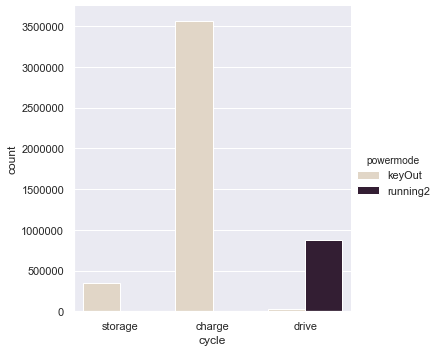

In [13]:
sns.catplot(x="cycle", kind="count", palette="ch:.25", data=df, hue='powermode');


 The table abow shows that cycle contain information about the powermode.
1. storage -> keyOut (conf = 1) 
1. charge -> keyOut (conf = 1) 
1. drive -> running (conf = 0.96) 

## Drive or Storage

In [31]:
not_charge = df_assoc[df_assoc['c_charge'] == 0]

In [32]:
not_charge.shape

(1252924, 40)

In [63]:
frq_items = apriori(not_charge , min_support = 0.6, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="confidence", min_threshold = 0.7) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 

In [64]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', None)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules[ (rules['antecedent_len'] >= 3) &
       (rules['confidence'] > 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
215,"(pm_running, max_temp_norm, imbalance_low)",(c_drive),0.623027,0.720602,0.623027,1.000000,1.387729,0.174073,inf,3
227,"(pm_running, traction_voltage_norm, max_temp_norm)",(c_drive),0.601180,0.720602,0.601180,1.000000,1.387729,0.167969,inf,3
239,"(pm_running, traction_voltage_norm, imbalance_low)",(c_drive),0.648553,0.720602,0.648553,1.000000,1.387729,0.181205,inf,3
277,"(max_temp_norm, imbalance_low, max_volt_norm)",(traction_voltage_norm),0.609786,0.861527,0.609783,0.999996,1.160725,0.084436,3.526512e+04,3
263,"(bs_noBalancing, traction_voltage_norm, max_temp_norm)",(imbalance_low),0.605469,0.980594,0.604754,0.998819,1.018585,0.011034,1.643011e+01,3
275,"(traction_voltage_norm, max_temp_norm, max_volt_norm)",(imbalance_low),0.619009,0.980594,0.609783,0.985096,1.004591,0.002787,1.302066e+00,3
253,"(traction_voltage_norm, max_temp_norm, c_drive)",(imbalance_low),0.621359,0.980594,0.610897,0.983164,1.002621,0.001597,1.152644e+00,3
286,"(traction_voltage_norm, max_temp_norm, num_cycle_low)",(imbalance_low),0.659930,0.980594,0.648730,0.983029,1.002483,0.001607,1.143496e+00,3
240,"(pm_running, traction_voltage_norm, c_drive)",(imbalance_low),0.659845,0.980594,0.648553,0.982886,1.002337,0.001512,1.133895e+00,3
216,"(pm_running, max_temp_norm, c_drive)",(imbalance_low),0.634098,0.980594,0.623027,0.982541,1.001985,0.001234,1.111489e+00,3


# Charge 

In [58]:
charge = df_assoc[df_assoc['c_charge'] == 1]

In [59]:
charge.shape

(3563607, 40)

In [69]:
frq_items = apriori(charge , min_support = 0.8, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="confidence", min_threshold = 0.7) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 

In [70]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', None)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules[ (rules['antecedent_len'] >= 3) &
       (rules['confidence'] > 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
188,"(pm_keyOut, max_temp_norm, imbalance_low)",(c_charge),0.906127,1.000000,0.906127,1.000000,1.000000,0.000000,inf,3
191,"(max_temp_norm, imbalance_low, c_charge)",(pm_keyOut),0.906127,1.000000,0.906127,1.000000,1.000000,0.000000,inf,3
202,"(pm_keyOut, max_temp_norm, vehicle_speed_zero)",(c_charge),0.918087,1.000000,0.918087,1.000000,1.000000,0.000000,inf,3
205,"(max_temp_norm, vehicle_speed_zero, c_charge)",(pm_keyOut),0.918087,1.000000,0.918087,1.000000,1.000000,0.000000,inf,3
216,"(pm_keyOut, max_temp_norm, num_cycle_low)",(c_charge),0.804302,1.000000,0.804302,1.000000,1.000000,0.000000,inf,3
218,"(max_temp_norm, c_charge, num_cycle_low)",(pm_keyOut),0.804302,1.000000,0.804302,1.000000,1.000000,0.000000,inf,3
230,"(pm_keyOut, imbalance_low, vehicle_speed_zero)",(c_charge),0.985302,1.000000,0.985302,1.000000,1.000000,0.000000,inf,3
233,"(imbalance_low, vehicle_speed_zero, c_charge)",(pm_keyOut),0.985302,1.000000,0.985302,1.000000,1.000000,0.000000,inf,3
244,"(pm_keyOut, traction_voltage_norm, imbalance_low)",(c_charge),0.826398,1.000000,0.826398,1.000000,1.000000,0.000000,inf,3
247,"(traction_voltage_norm, imbalance_low, c_charge)",(pm_keyOut),0.826398,1.000000,0.826398,1.000000,1.000000,0.000000,inf,3


## Results

During assosiation rules meaning no meaningful rules for high imbalace were found. However, it was discovered, that powermode can be shown via cycle, therefore this attribute will be removed.